# ATOC5860 - estimate_effective_sample_size - Lecture #5
### coded by Prof. Jennifer Kay (University of Colorado)
### last updated: January 31, 2024

In [8]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xarray
import pandas as pd   ##pandas reads in .csv.
from scipy import stats

In [9]:
## Read in your data
## Data are from the NCAR mesa lab weather station in Boulder Colorado
## These data can be seen in real-time here: https://archive.eol.ucar.edu/cgi-bin/weather.cgi?site=ml
## Note: December 29-31, 2021 was a crazy three days on many levels - Went from very windy/dry to Snow!
## Note: The Marshall Fire started on December 30, 2021

filename = 'mesa_lab_data_dec29-31_2021_nomissing.csv'
data=pd.read_csv(filename,sep=',')
print(data.head())
print(data.tail())
data

   days  hour_frac     pres_mb  tdry_degC  rh_percent  wdir  wspd_m_per_s  \
0   363   0.000000  794.799988       -1.9   33.200001   176           6.4   
1   363   0.083333  794.900024       -2.1   33.599998   183           6.8   
2   363   0.166667  794.900024       -2.0   32.799999   177           7.1   
3   363   0.250000  794.900024       -2.1   33.099998   183           4.8   
4   363   0.333333  794.900024       -2.3   33.099998   181           5.5   

   wspdmax_m_per_s  raina_event_mm  Unnamed: 9  
0              9.9             0.0           1  
1              9.3             0.0           2  
2              9.8             0.0           3  
3              8.2             0.0           4  
4              7.5             0.0           5  
     days  hour_frac     pres_mb  tdry_degC  rh_percent  wdir  wspd_m_per_s  \
859   365  23.583333  794.900024       -4.4   86.500000   100           1.8   
860   365  23.666667  795.000000       -4.4   86.500000    87           2.0   
861   

,days,hour_frac,pres_mb,tdry_degC,rh_percent,wdir,wspd_m_per_s,wspdmax_m_per_s,raina_event_mm,Unnamed: 9
0,363,0.000000,794.799988,-1.9,33.200001,176,6.4,9.9,0.0,1
1,363,0.083333,794.900024,-2.1,33.599998,183,6.8,9.3,0.0,2
2,363,0.166667,794.900024,-2.0,32.799999,177,7.1,9.8,0.0,3
3,363,0.250000,794.900024,-2.1,33.099998,183,4.8,8.2,0.0,4
4,363,0.333333,794.900024,-2.3,33.099998,181,5.5,7.5,0.0,5
...,...,...,...,...,...,...,...,...,...,...
859,365,23.583333,794.900024,-4.4,86.500000,100,1.8,4.8,0.0,860
860,365,23.666667,795.000000,-4.4,86.500000,87,2.0,5.2,0.0,861
861,365,23.750000,795.099976,-4.5,86.599998,100,1.6,4.6,0.0,862
862,365,23.833333,795.099976,-4.4,86.699997,84,2.4,4.5,0.0,863


(864,)


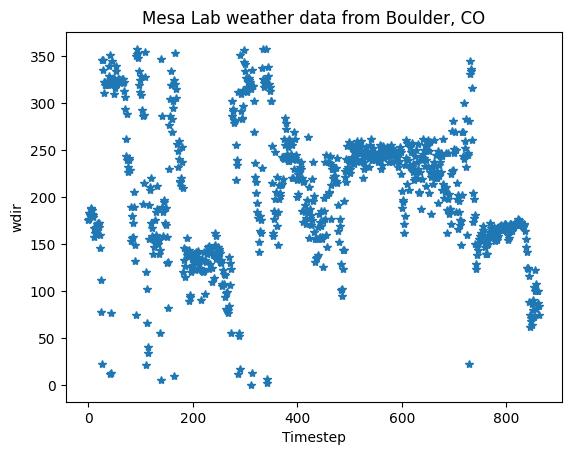

In [10]:
## Look at data
variable='wdir' ## try 'pres_mb', 'tdry_degC', 'rh_percent', 'wdir', 'wspd_m_per_s', 'wspdmax_m_per_s'
tseries=data[variable]
print(tseries.shape)
plt.plot(tseries,'*');  ## quick plot to look at data
plt.title('Mesa Lab weather data from Boulder, CO');
plt.ylabel(variable);
plt.xlabel('Timestep');

(144,)
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5
 49.  49.5 50.  50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5
 56.  56.5 57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  61.5 62.  62.5
 63.  63.5 64.  64.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5
 70.  70.5 71.  71.5]
(144,)


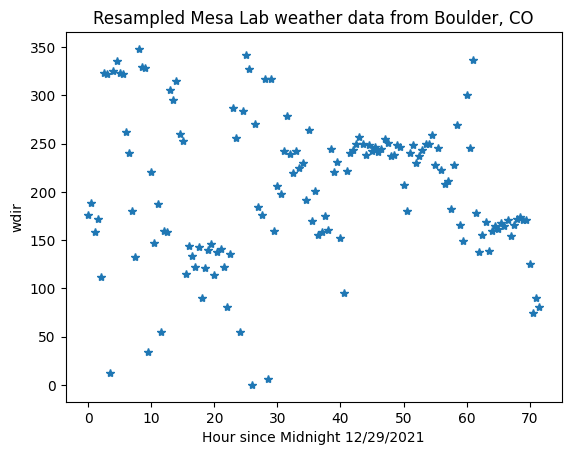

In [27]:
## Resample the data every Nhrs and Plot it again
Nhrs=0.5 ## sampling rate in hours
Ndays=3
hours=np.arange(0,24*Ndays,Nhrs*1.)
print(hours.shape)
print(hours)
samples_per_hour=12
tseries_resampled=tseries[::int(samples_per_hour*Nhrs)] ## take the temperature every Nhrs
print(tseries_resampled.shape)

plt.plot(hours,tseries_resampled,'*');    ## quick plot to look at data sampled every 3 hours
plt.title('Resampled Mesa Lab weather data from Boulder, CO');
plt.ylabel(variable);
plt.xlabel('Hour since Midnight 12/29/2021');
#print(tseries_resampled)

In [28]:
### Calculate some basic statistics about your data variable
#data=tseries
data=tseries_resampled

N=len(data)
sigma=np.std(data)  ## calculate the standard deviation
mean=np.mean(data)  ## calculate the mean
print(f'Sample Size N: {N}')
print(f'Mean: {round(mean,1)}')
print(f'Standard Deviation: {round(sigma,1)}')

Sample Size N: 144
Mean: 202.9
Standard Deviation: 73.9


In [29]:
## Estimate lag-1 autocorrelation
lag=1
t1_m=data.iloc[0:-1*lag]-mean
t2_m=data.iloc[lag:]-mean

#Method #1
#Calculate the autocorrelation using numpy correlate lagN
AR1_np=np.correlate(t1_m,t2_m,mode='valid')/(N-lag)/(sigma**2)
print(f'np.correlate AR1: {round(AR1_np[0],5)}')

#Method #2
#Calculate the autocorrelation using numpy dot (direct calculation)
## (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)
AR1=np.dot(t1_m,t2_m)/(N-lag)/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance
print(f'direct calculation AR1: {round(AR1,5)}')

print('Did you get the same answer using np.correlate and the direct calculation')

np.correlate AR1: 0.21881
direct calculation AR1: 0.21881
Did you get the same answer using np.correlate and the direct calculation


In [30]:
## Calculate effective sample size (N*)
## Note: Leith function to estimate N* is not well behaved for large autocorrelations
## Prof. Kay recommends using Wilks

Nstar_wilks=round(((1-AR1)/(1+AR1))*N) ## Barnes Chapter 2 eq. 88
Nstar_leith=round((-0.5*np.log(AR1))*N) ## Barnes Chapter 2 eq. 90
print('Number of samples N:',N)
print(f'Effective Sample Size Wilks N* (#independent samples): {Nstar_wilks}')
print(f'Effective Sample Size Leith N* (#independent samples): {Nstar_leith}')

Number of samples N: 144
Effective Sample Size Wilks N* (#independent samples): 92
Effective Sample Size Leith N* (#independent samples): 109


### Recommended tinkering:
1) Assess the autocorrelation and N* for different weather variables
2) Assess the influence of resampling.  Why might you resample your data before estimating N*?